<a href="https://colab.research.google.com/github/ilaig2/siren/blob/master/siren_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [ ]:
from collections import OrderedDict
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

#Ilai: My code starts here

(All the code above is from the original Siren repo, unchanged)

## Load the data from Google Drive
Gotta love Google for the easy intergration here...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
images = glob('/content/drive/MyDrive/Data/48/*.png')

# Fitting multiple images

By adding an additional input dimension which encodes the image index - the network is able to learn the representations of multiple images.

In [ ]:
def image_transforms(img , sidelength):
      transform = Compose([
        Resize((sidelength, sidelength)),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
      img = transform(img)
      return img

class MultiImageFitting(Dataset):
    def __init__(self, sidelength, image_paths):
        super().__init__()
        self.sidelength = sidelength
        self.image_paths = image_paths[:50]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):    
        img = Image.open(self.image_paths[idx])
        img = image_transforms(img, self.sidelength)
        pixels = img.permute(1, 2, 0).view(-1, img.shape[0])
        pixels = pixels[:, :3]
        coords = get_mgrid(self.sidelength, 2)
        
        # Add another "channel" encoding image number in the dataset
        coords = torch.hstack([coords, (idx / len(self.image_paths)) * torch.ones((coords.shape[0], 1))])
            
        return coords, pixels

In [ ]:
SIDELENGTH = 48
camera_and_coins = MultiImageFitting(SIDELENGTH, images)
dataloader = DataLoader(camera_and_coins, batch_size=10, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=3, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
# TODO: Change sequentail init to OrderedDict
for layer in img_siren.parameters():
  print (layer.name, layer.shape)

None torch.Size([256, 3])
None torch.Size([256])
None torch.Size([256, 256])
None torch.Size([256])
None torch.Size([256, 256])
None torch.Size([256])
None torch.Size([256, 256])
None torch.Size([256])
None torch.Size([3, 256])
None torch.Size([3])


In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

for step in range(total_steps):
  for model_input, ground_truth in dataloader:
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    model_output, coords = img_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    optim.zero_grad()
    loss.backward()
    optim.step()

  if not step % steps_til_summary:
    print("Step %d, Total loss %0.6f" % (step, loss))

Step 0, Total loss 0.459435
Step 10, Total loss 0.198385
Step 20, Total loss 0.180904
Step 30, Total loss 0.163433
Step 40, Total loss 0.150050
Step 50, Total loss 0.137018
Step 60, Total loss 0.121468
Step 70, Total loss 0.105973
Step 80, Total loss 0.092286
Step 90, Total loss 0.078846
Step 100, Total loss 0.068613
Step 110, Total loss 0.056865
Step 120, Total loss 0.055313
Step 130, Total loss 0.044670
Step 140, Total loss 0.041041
Step 150, Total loss 0.035527
Step 160, Total loss 0.031367
Step 170, Total loss 0.028572
Step 180, Total loss 0.025993
Step 190, Total loss 0.023527
Step 200, Total loss 0.021487
Step 210, Total loss 0.018206
Step 220, Total loss 0.016929
Step 230, Total loss 0.017437
Step 240, Total loss 0.016688
Step 250, Total loss 0.015461
Step 260, Total loss 0.013036
Step 270, Total loss 0.011938
Step 280, Total loss 0.010660
Step 290, Total loss 0.019426
Step 300, Total loss 0.009974
Step 310, Total loss 0.009658
Step 320, Total loss 0.009753
Step 330, Total loss 

# Verify trained model forward() for various resolutions
Since the model is size agnostic, it can up\downsample the image to any desired resolution (to some precision...)

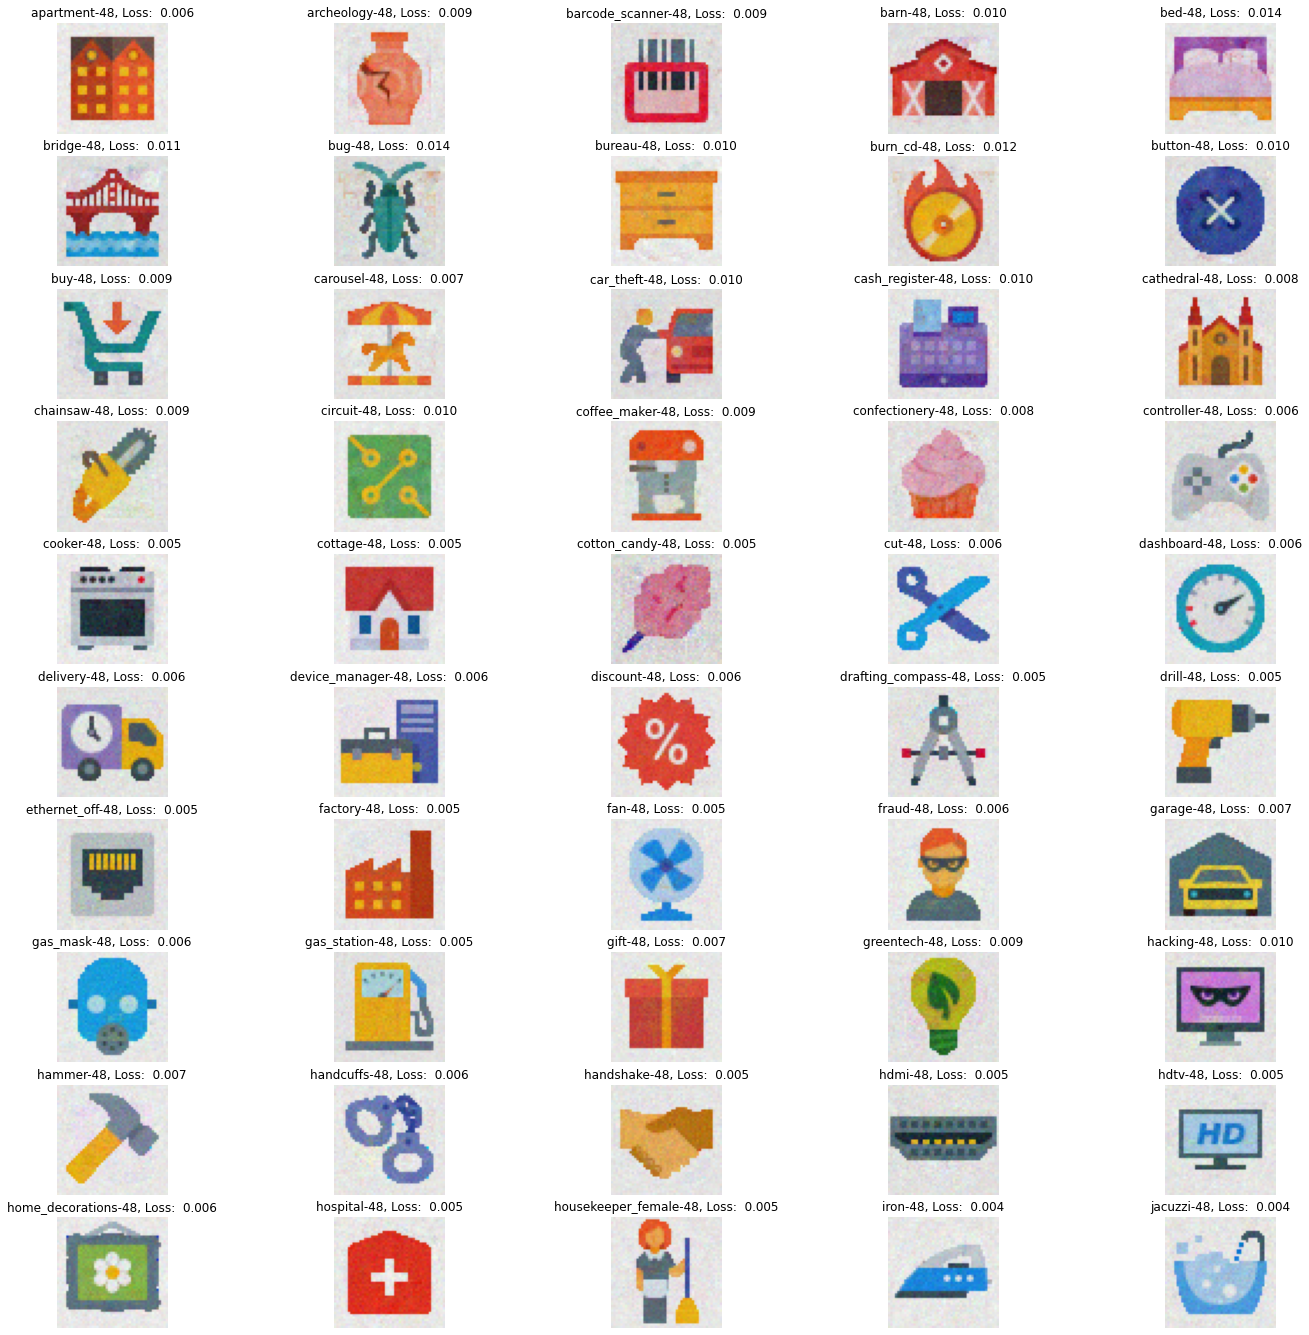

In [ ]:
NEW_SIDELENGTH = 48
camera_and_coins = MultiImageFitting(NEW_SIDELENGTH, images)
dataloader = DataLoader(camera_and_coins, batch_size=1, pin_memory=True, num_workers=0)

fig, axs = plt.subplots(10, 5, figsize=[24,24])

with torch.no_grad():
  for i, (coords, GT) in enumerate(dataloader):
      model_output, _ = img_siren(coords.cuda())
      model_output = model_output.cpu()
      loss = ((model_output - GT)**2).mean()
      model_output = model_output.view(NEW_SIDELENGTH,NEW_SIDELENGTH, 3).numpy()
      model_output -= model_output.min()
      model_output /= (model_output.max() - model_output.min())
      axs[(i //5) % 10, i % 5].imshow(model_output, cmap='gray')
      axs[(i //5) % 10, i % 5].set_title(f"{os.path.splitext(os.path.basename(images[i]))[0]}, Loss: {loss : .3f}")
      axs[(i //5) % 10, i % 5].axis(False)

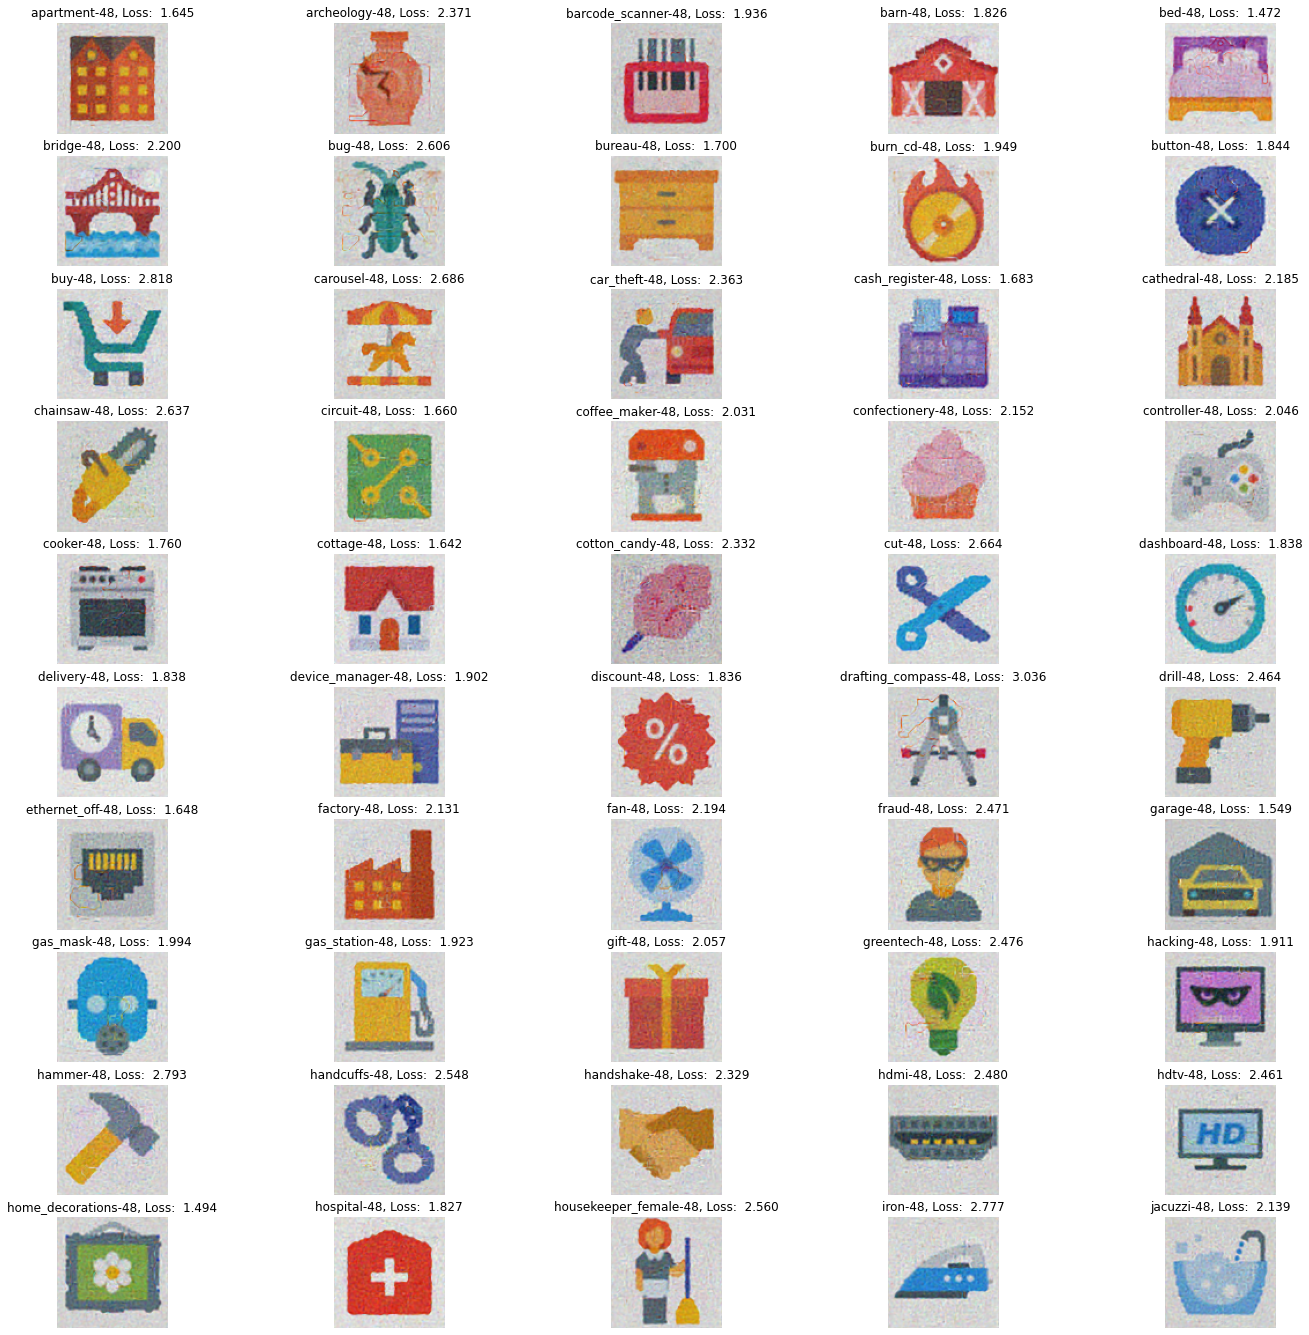

In [ ]:
NEW_SIDELENGTH = 96
camera_and_coins = MultiImageFitting(NEW_SIDELENGTH, images)
dataloader = DataLoader(camera_and_coins, batch_size=1, pin_memory=True, num_workers=0)

fig, axs = plt.subplots(10, 5, figsize=[24,24])

with torch.no_grad():
  for i, (coords, GT) in enumerate(dataloader):
      model_output, _ = img_siren(coords.cuda())
      model_output = model_output.cpu()
      loss = ((model_output - GT)**2).mean()
      model_output = model_output.view(NEW_SIDELENGTH,NEW_SIDELENGTH, 3).numpy()
      model_output -= model_output.min()
      model_output /= (model_output.max() - model_output.min())
      axs[(i //5) % 10, i % 5].imshow(model_output, cmap='gray')
      axs[(i //5) % 10, i % 5].set_title(f"{os.path.splitext(os.path.basename(images[i]))[0]}, Loss: {loss : .3f}")
      axs[(i //5) % 10, i % 5].axis(False)